In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from fastai.vision.all import *
from fastai import *
from fastai.vision import *
#from torchsummary import summary

from modules.gradcam import *
from modules.guided_backpropagation import *
from modules.saliency_map import *
from modules.occlusion_map import *
from modules.score_cam import * 
from modules.visualize_kernels import *
from modules.visualize_activations import *

import sys
sys.path.insert(0, "/mnt/home/Martin.Gerstmaier/projects/pytorch_notebooks/modules/")

torch.cuda.empty_cache()
from IPython.core.interactiveshell import InteractiveShell

In [2]:
def prepare_data(img_size, batch_size):
    path = "../../../data/imagenette2-320/"
    item_tfms=RandomResizedCrop(size=img_size, min_scale=0.8)
    batch_tfms=[*aug_transforms(flip_vert=False, max_lighting=0.2, max_rotate=15., max_zoom=1.1, max_warp=0.2, p_affine=0.75, p_lighting=0.75), 
                Normalize.from_stats(*imagenet_stats)]
    dls = ImageDataLoaders.from_folder(path, valid='val', item_tfms=item_tfms, batch_tfms=batch_tfms, bs=batch_size)  
    return dls

dls = prepare_data(224, 20)

# load data to analyze
def load_images(no_images_per_class):
    paths = "../../../data/imagenette2-320/val/"
    images = []
    for path in os.listdir(paths):
        for image in os.listdir(paths+path)[:no_images_per_class]:
            images.append(PILImage.create(paths+path+"/"+image))

    print("Analyzing " + str(len(images)) + " of the validation data set")
    return images

images = load_images(100)

Analyzing 1000 of the validation data set


In [3]:
# Load images
img1 = PILImage.create('./../images/dog1.JPEG')
img2 = PILImage.create('./../images/parachute_middle.jpg')
img3 = PILImage.create('./../images/fish2.JPEG')
img4 = PILImage.create('./../images/dog2.JPEG')
img5 = PILImage.create('./../images/goldfish.jpg')

In [4]:
CLASSES = 10
# CNN
from ResNets import resnet50
model = resnet50(num_classes=CLASSES)
CNN = Learner(dls, model, opt_func=Adam, metrics=accuracy) 
CNN.load("../my_saved_models/cnn/imagenette2021-07-30_17:00:44_CNN_1e-2")

# BoTNet
num_heads = 4
from BoTNet_Model import resnet50
model = resnet50(num_classes=CLASSES, attention=[False,False,False,True], num_heads=num_heads, inference=True, shuffle_weights=False)
BoTNet = Learner(dls, model, opt_func=Adam, metrics=accuracy)  
BoTNet.load("../my_saved_models/attention/imagenette2021-06-28_15:55:28_BotNet_1e-4")
BoTNet.cuda()

num_heads = 8
from AACN_Model import resnet50
model = resnet50(num_classes=CLASSES, attention=[False,False,True,True], num_heads=num_heads, k=2, v=0.2, inference=True)
AACN = Learner(dls, model, opt_func=Adam, metrics=accuracy) 
AACN.load("../my_saved_models/attention/imagenette2021-08-02_18:09:25_AACN_1e-4_v02_2CL")
AACN.cuda()

from Axial_Model import resnet50
model = resnet50(num_classes=CLASSES, attention=[False,False,True,True], num_heads=num_heads, inference=True)
Axial = Learner(dls, model, opt_func=Adam, metrics=accuracy) 
Axial.load("../my_saved_models/attention/imagenette2021-08-02_09:59:47_Axial_1e-2_2CL")
Axial.cuda()

from SASA_Model import resnet50
model = resnet50(num_classes=CLASSES, attention=[False,False,True,True], num_heads=num_heads, kernel_size=9, inference=True)
SASA = Learner(dls, model, opt_func=Adam, metrics=accuracy) 
# SASA.load("../my_saved_models/attention/imagenette2021-08-01_17:19:19_SASA_1e-3_k9_2CL")
# SASA.load("../my_saved_models/attention/imagenette2021-07-31_19:55:53_SASA_1e-3_k9")
SASA.load("../my_saved_models/attention/imagenette2021-09-16_15:43:11_SASA_1e-3")
SASA.cuda()

models = [CNN, BoTNet, AACN, Axial, SASA]
#models = [BoTNet, AACN, SASA]

/home/Martin.Gerstmaier/anaconda3/envs/pytorch/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


## chexpert

In [2]:
chexpert_labels_train = pd.read_csv("/mnt/home/Martin.Gerstmaier/netstore/data/CheXpert-v1.0-small/train.csv")
sys.path.insert(0, "/mnt/home/Martin.Gerstmaier/projects/pytorch_notebooks/chexpert")
from load_chexpert import *


# without augmentations
CHEXPERT_STATS = ([0.5012334011729692, 0.5012334011729692, 0.5012334011729692],
                  [0.2927409033334009, 0.2927409033334009, 0.2927409033334009])
def create_dataloader(df, img_size, batch_size):
    path = "/mnt/home/Martin.Gerstmaier/netstore/data/"
    def get_x(df): return path+df['Path']
    def get_y(df): return df['labels']
    def splitter(df):
        train = df.index[~df['is_valid']].tolist()
        val = df.index[df['is_valid']].tolist()
        return train, val
    batch_tfms=[Normalize.from_stats(*CHEXPERT_STATS)]
    item_tfms=[Resize(size=img_size)]
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
                               splitter=splitter, 
                               get_x=get_x, 
                               get_y=get_y,
                               item_tfms=item_tfms, 
                               batch_tfms=batch_tfms
                              )
    return dblock.dataloaders(df, bs=batch_size)

df, pos_weights = prepare_data(chexpert_labels_train, percentage=5, pos_weight=False)
dls = create_dataloader(df, img_size=224, batch_size=20)

print("Prepared Data")

CLASSES = 5
files_path = "/mnt/home/Martin.Gerstmaier/netstore/data/chexpert-logs/my_saved_models/"

# CNN
from ResNets import resnet50
model = resnet50(num_classes=CLASSES)
CNN = Learner(dls, model, opt_func=Adam, loss_func=nn.BCEWithLogitsLoss(pos_weight=pos_weights), metrics= [RocAucMulti(), partial(accuracy_multi, thresh=0.5)]) 
CNN.load(files_path + "cnn/chexpert2021-07-29_18:21:08_CNN_1e-3")
CNN.cuda()

# BoTNet
num_heads = 4
from BoTNet_Model import resnet50
model = resnet50(num_classes=CLASSES, attention=[False,False,False,True], num_heads=num_heads, inference=True, shuffle_weights=False)
BoTNet = Learner(dls, model, opt_func=Adam, loss_func=nn.BCEWithLogitsLoss(pos_weight=pos_weights), metrics= [RocAucMulti(), partial(accuracy_multi, thresh=0.5)])
BoTNet.load(files_path + "attention/chexpert2021-08-02_11:33:51_BoTNet_1e-4")
BoTNet.cuda()

num_heads = 8
from AACN_Model import resnet50
model = resnet50(num_classes=CLASSES, attention=[False,False,True,True], num_heads=num_heads, k=2, v=0.2, inference=True)
AACN = Learner(dls, model, opt_func=Adam, loss_func=nn.BCEWithLogitsLoss(pos_weight=pos_weights), metrics= [RocAucMulti(), partial(accuracy_multi, thresh=0.5)]) 
AACN.load(files_path + "attention/chexpert2021-08-19_19:00:12_AACN_1e-4_v02_2CL")
AACN.cuda()

from Axial_Model import resnet50
model = resnet50(num_classes=CLASSES, attention=[False,False,True,True], num_heads=num_heads, inference=True)
Axial = Learner(dls, model, opt_func=Adam, loss_func=nn.BCEWithLogitsLoss(pos_weight=pos_weights), metrics= [RocAucMulti(), partial(accuracy_multi, thresh=0.5)]) 
Axial.load(files_path + "attention/chexpert2021-08-07_11:25:45_Axial_1e-4_2CL")
Axial.cuda()

from SASA_Model import resnet50
model = resnet50(num_classes=CLASSES, attention=[False,False,True,True], num_heads=num_heads, kernel_size=9, inference=True)
SASA = Learner(dls, model, opt_func=Adam, loss_func=nn.BCEWithLogitsLoss(pos_weight=pos_weights), metrics= [RocAucMulti(), partial(accuracy_multi, thresh=0.5)]) 
# SASA.load(files_path + "attention/chexpert2021-08-05_09:27:00_SASA_1e-3_2CL_k9")
SASA.load(files_path + "attention/chexpert2021-09-21_10:07:52_SASA_1e-3_2CL_k9") 
SASA.cuda()
models = [CNN, BoTNet, AACN, Axial, SASA]
print("Loaded models")

Preparing data..
Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'Cardiomegaly',
       'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion', 'patient',
       'study', 'labels'],
      dtype='object')
Using 223414 images
Using 5 percent of data as validation set
Prepared Data


/home/Martin.Gerstmaier/anaconda3/envs/pytorch/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Loaded models


In [4]:
a = pd.read_csv("/mnt/home/Martin.Gerstmaier/data/BBox_List_2017.csv")
len(a)

984

In [5]:
from tqdm import tqdm
# load images with bounding boxes
def load_images(no_images):
    bb_csv = "/mnt/home/Martin.Gerstmaier/data/BBox_List_2017.csv"
    bb_df = pd.read_csv(bb_csv)[:no_images]
    bb_df["path"] = ""
    paths = "/mnt/dsets/CheXNet14/"
    images = []
    for image_folder in tqdm(os.listdir(paths)):
        if os.path.isdir(paths+image_folder):
            for image in os.listdir(paths+image_folder+"/images/"):
                if bb_df["Image Index"].str.contains(image).any():
                    row_idx = bb_df.index[bb_df["Image Index"].str.contains(image)]
                    bb_df.loc[row_idx, "path"] = paths+image_folder+"/images/"+image
    print("Analyzing " + str(len(images)) + " images of the validation data set")
    return bb_df
df = load_images(170)
len(df)

100%|██████████| 26/26 [00:34<00:00,  1.34s/it]

Analyzing 0 images of the validation data set


170

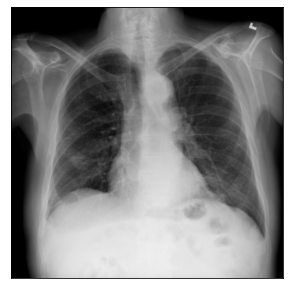

In [5]:
cur_image = PILImage.create(df.path[0])
cls, preds, _ = CNN.predict(cur_image)
preds, preds.softmax(0)
fig = plt.figure()
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
axes = gs.subplots(sharex=True, sharey=True)
fig.set_size_inches(5, 5)
axes.set_xticks([])
axes.set_yticks([])
axes.imshow(cur_image, alpha=1, extent=(0,224,224,0), interpolation='bilinear')

In [102]:
learn = BoTNet
## find correct images
def plot_with_bb(row):
    cur_image = PILImage.create(row.path)
    cls, preds, _ = learn.predict(cur_image)
    classes = learn.dls.vocab
    prediction = classes[torch.argmax(preds)]
  #  print(" Groundtruth: ", row["Finding Label"], ", Prediction: ", prediction)
    if row["Finding Label"] == prediction:# and torch.argmax(preds) > 0.2:
   #     print("Found one")
        return True
    return False

correct_predictions = []
for i in range(len(df)):
    if plot_with_bb(df.loc[i]):
        correct_predictions.append(i) 

In [4]:
# find correct images
def plot_with_bb(learn, row, idx):
    classes = list(learn.dls.vocab)
    if row["Finding Label"] in classes:
        cur_image = PILImage.create(row.path)
       # cls, preds, _ = learn.predict(cur_image)
        img, = first(learn.dls.test_dl([cur_image]))
        class_idx = classes.index(row["Finding Label"])
       # prediction = classes[torch.argmax(preds)]
       # print(" Groundtruth: ", row["Finding Label"], ", Prediction: ", prediction)
       # if row["Finding Label"] == prediction:
        layer=learn.model.layer4

        fig, axes = plt.subplots(1,1,figsize=(5,5))
        axes.axis('off')
        fig.tight_layout(pad=0)   
        size = row.shape[-1]      
        print(row["Finding Label"])
        coords = [(row['Bbox [x'], row['y']), row['w'], row['h]']]
        rect = matplotlib.patches.Rectangle(coords[0], coords[1], coords[2], linewidth=2, edgecolor='r', facecolor='none')       
        axes.imshow(cur_image, interpolation='bilinear')
        axes.add_patch(rect)  

# for i in range(5, 15):
#     plot_with_bb(df.loc[i], i)

In [5]:
CNN.dls.vocab

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

Cardiomegaly


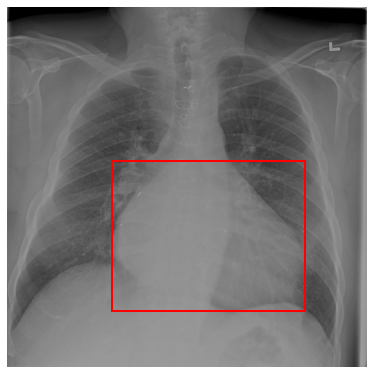

In [6]:
idx = 163
plot_with_bb(CNN, df.loc[idx], idx)
img2 = PILImage.create(df.path[idx])
CNN.predict(img2)[1]
matplotlib.rcParams.update({'font.size': 45})

In [ ]:
Cardiomegaly 58, 163, 284

In [ ]:
Atelectasis 3, 26, 515

## Activations

In [ ]:
für Imagenette images[19], img1, img2

In [7]:
matplotlib.rcParams.update({'font.size': 45})

In [21]:
img = img2
activations = []
for model in models:
    activations.append(visualize_activations(model, img, layer=model.layer4))

[Text(0, 0.5, 'Activations')]

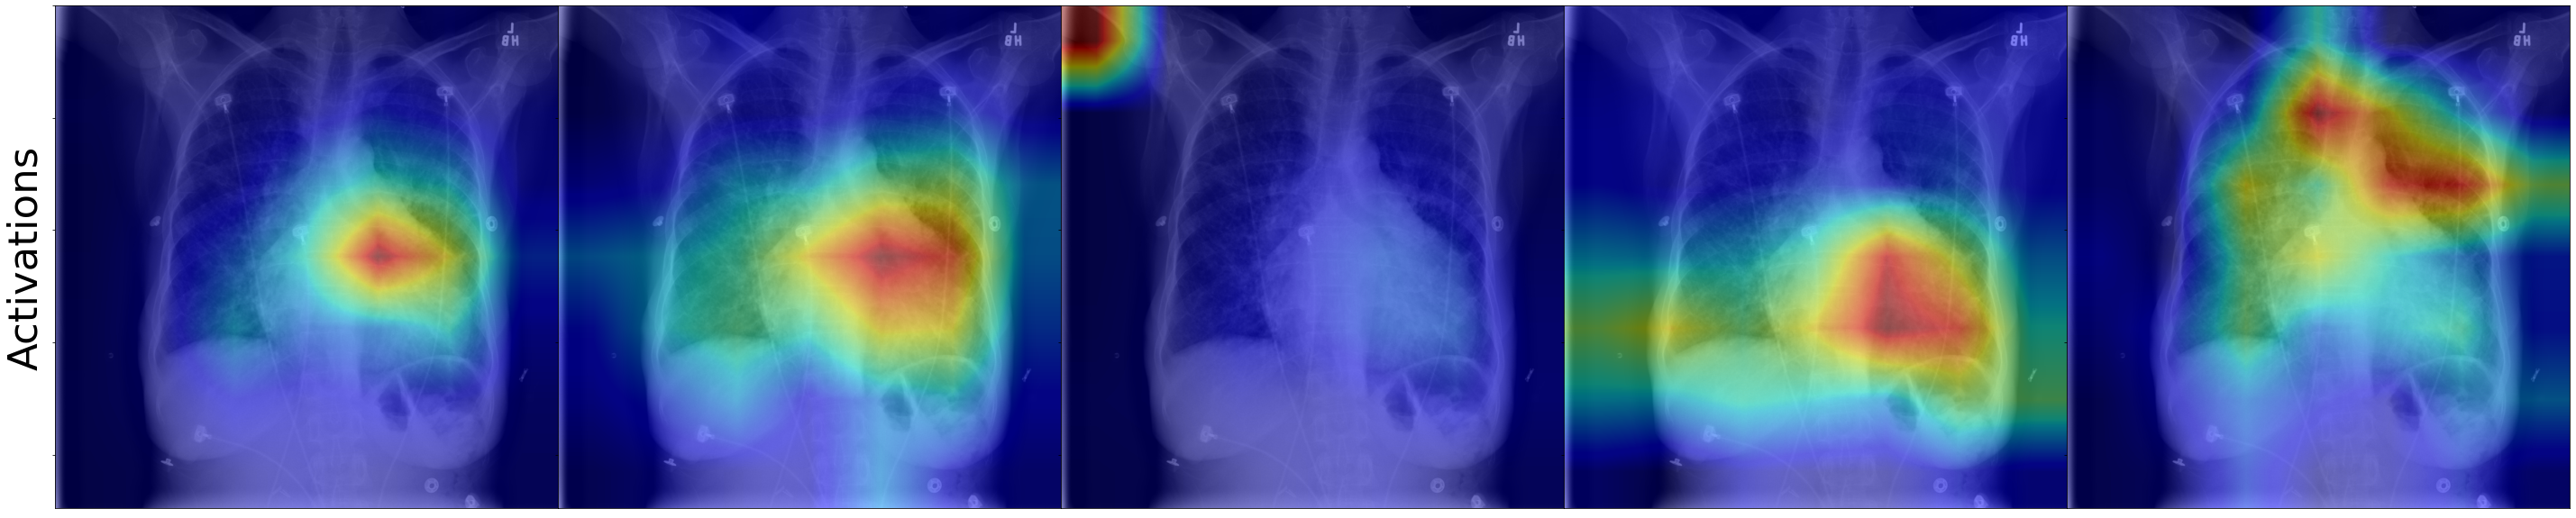

In [22]:
summed_activations = []
for act in activations:
    act = act.squeeze(0).sum(-1)
    summed_activations.append(act)

fig = plt.figure()
gs = fig.add_gridspec(1, len(summed_activations), hspace=0, wspace=0)
axes = gs.subplots(sharex=True, sharey=True)
fig.set_size_inches(50, 35)
i = 0
for act in summed_activations:
    axes[i].imshow(img, alpha=1, extent=(0,224,224,0),
                  interpolation='bilinear')
    axes[i].imshow(act.cpu(),cmap="jet", alpha=0.5, extent=(0,224,224,0),
                  interpolation='bilinear')

    axes[i].set_xticks([])
    axes[i].set_yticklabels([])
    i+=1

axes.flat[0].set(ylabel="Activations")

## GradCam

In [23]:
img = img2
prediction = CNN.predict(img)
class_idx = prediction[1]
class_idx = 1
activations = []
for model in models:
    activations.append(gradcam(model, img, class_idx, layer=model.model.layer4, display=False))

[Text(0, 0.5, 'Grad-CAM')]

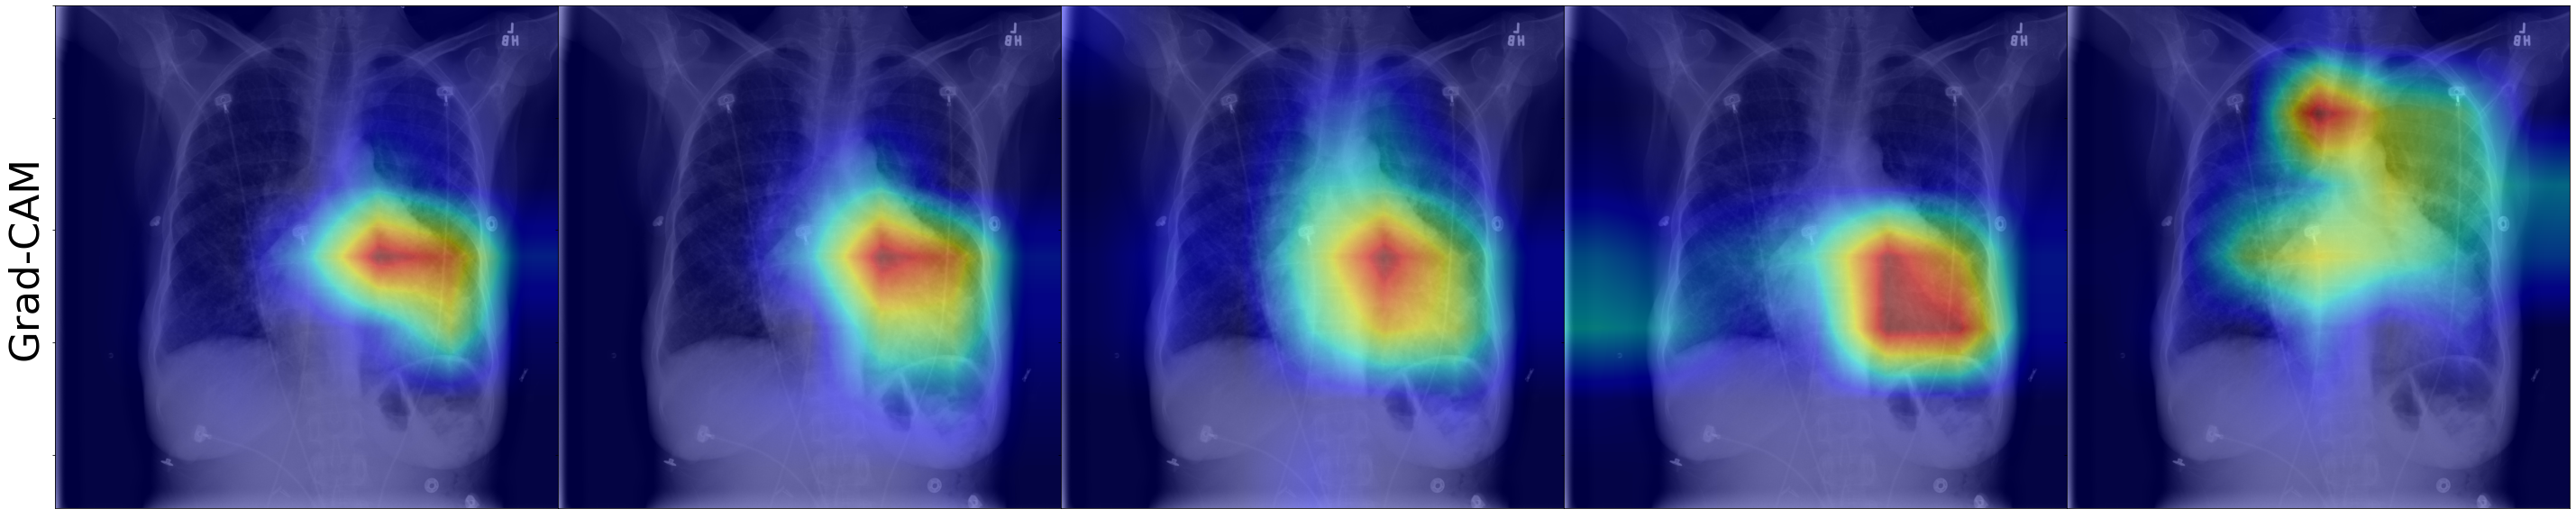

In [24]:
fig = plt.figure()
gs = fig.add_gridspec(1, len(activations), hspace=0, wspace=0)
axes = gs.subplots(sharex=True, sharey=True)
fig.set_size_inches(50, 35)
i = 0
for act in activations:
    axes[i].imshow(img, alpha=1, extent=(0,224,224,0),
                  interpolation='bilinear')
    axes[i].imshow(act,cmap="jet", alpha=0.5, extent=(0,224,224,0),
                  interpolation='bilinear')
    
    axes[i].set_xticks([])
    axes[i].set_yticklabels([])
    i+=1

axes.flat[0].set(ylabel="Grad-CAM")

## SmoothGrad 

In [5]:
img = img2
prediction = CNN.predict(img)
class_idx = prediction[1]
class_idx = 1
activations = []
for model in models:
    activations.append(saliency_map(model, img, class_idx, repeats=25, noise=0.4))

[Text(0, 0.5, 'SmoothGrad')]

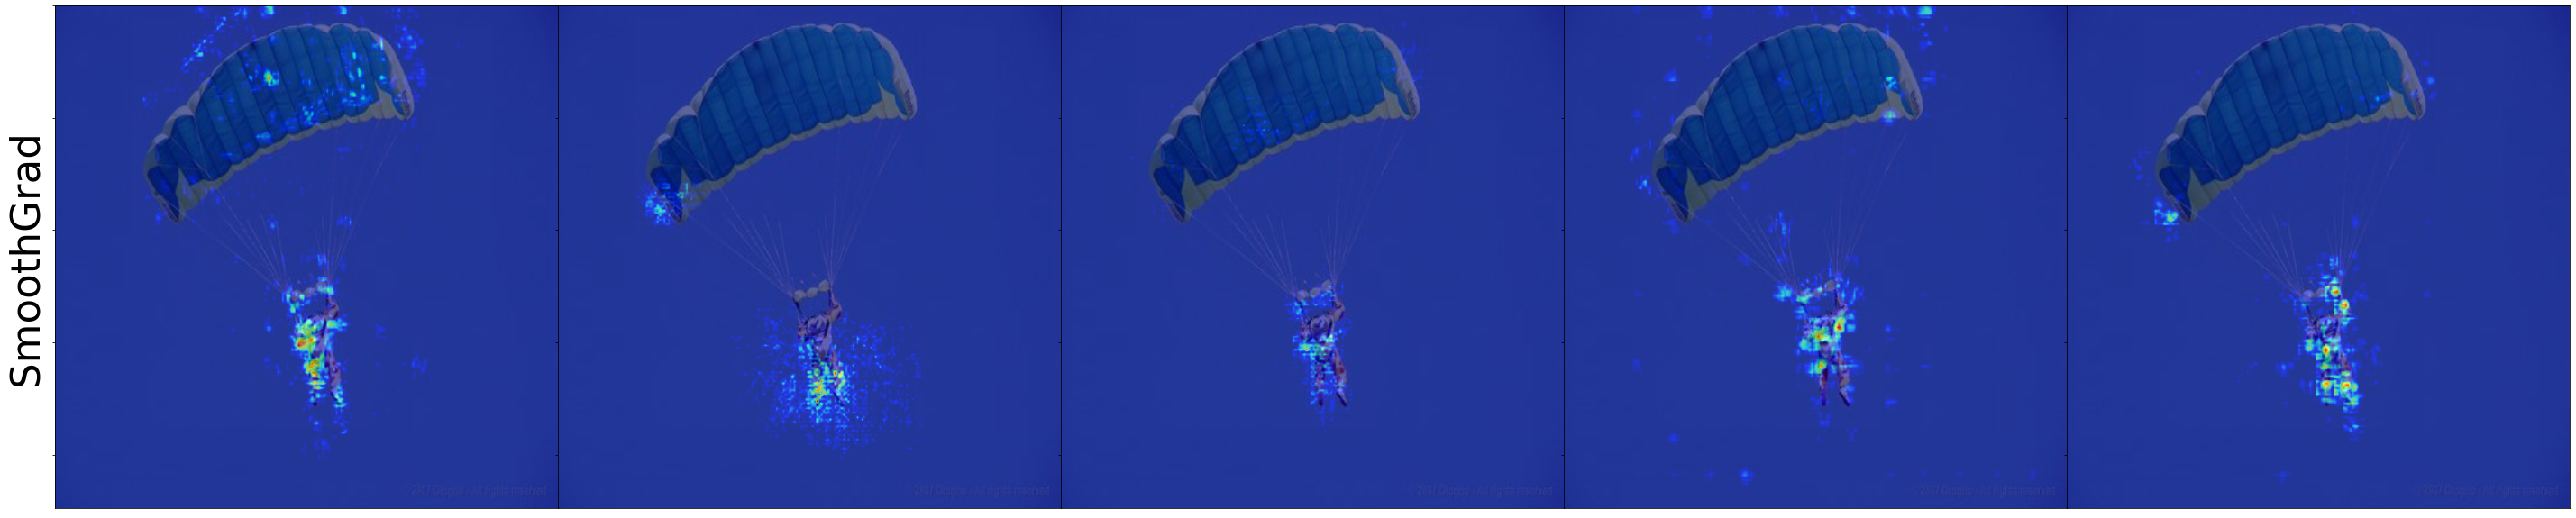

In [8]:
fig = plt.figure()
gs = fig.add_gridspec(1, len(activations), hspace=0, wspace=0)
axes = gs.subplots(sharex=True, sharey=True)
fig.set_size_inches(50, 35)
i = 0
for act in activations:
    axes[i].imshow(img, alpha=1, extent=(0,224,224,0),
                  interpolation='bilinear')
    axes[i].imshow(act,cmap="jet", alpha=0.6, clim=[0.1,1], extent=(0,224,224,0),
                  interpolation='bilinear')
    
    axes[i].set_xticks([])
    axes[i].set_yticklabels([])
    i+=1

axes.flat[0].set(ylabel="SmoothGrad")

## Guided Backprop

In [34]:
img = img2
prediction = CNN.predict(img)
class_idx = prediction[1]
class_idx = 1
activations = []
for model in models:
    activations.append(guided_backprop(model, img, class_idx))

[Text(0, 0.5, 'Guided Backpropagation')]

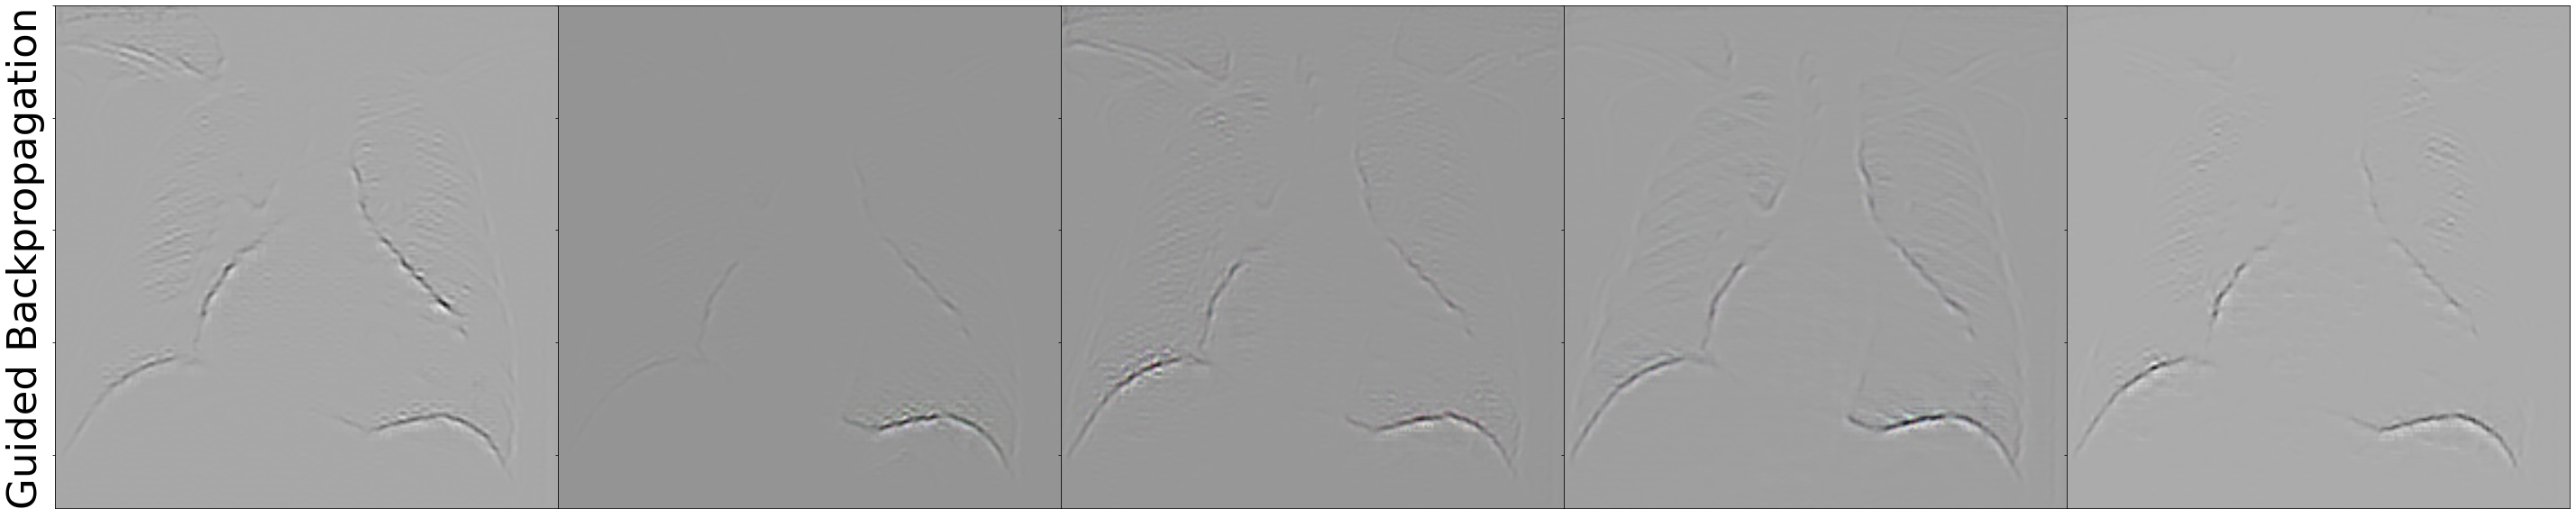

In [35]:
fig = plt.figure()
gs = fig.add_gridspec(1, len(activations), hspace=0, wspace=0)
axes = gs.subplots(sharex=True, sharey=True)
fig.set_size_inches(50, 35)
i = 0
for act in activations:
    axes[i].imshow(act,cmap="jet", alpha=1, extent=(0,224,224,0),
                  interpolation='bilinear')

    axes[i].set_xticks([])
    axes[i].set_yticklabels([])
    i+=1

axes.flat[0].set(ylabel="Guided Backpropagation")

## Guided Gradcam

In [36]:
img = img2
prediction = CNN.predict(img)
class_idx = prediction[1]
activations = []
for model in models:
    activations.append(guided_gradcam(guided_backprop(model, img, class_idx), gradcam(model, img, class_idx, layer = model.model.layer4)))

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
fig = plt.figure()
gs = fig.add_gridspec(1, len(activations), hspace=0, wspace=0)
axes = gs.subplots(sharex=True, sharey=True)
fig.set_size_inches(50, 35)
i = 0
for act in activations:
    axes[i].imshow(act,cmap="jet", alpha=1, extent=(0,224,224,0),
                  interpolation='bilinear')

    axes[i].set_xticks([])
    axes[i].set_yticklabels([])
    i+=1

axes.flat[0].set(ylabel="Guided GradCAM")

## Score-CAM

In [9]:
img = img1
prediction = CNN.predict(img)
class_idx = prediction[1]
activations = []
for model in models:
    activations.append(score_cam(model, img, class_idx))

/home/Martin.Gerstmaier/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[Text(0, 0.5, 'ScoreCAM')]

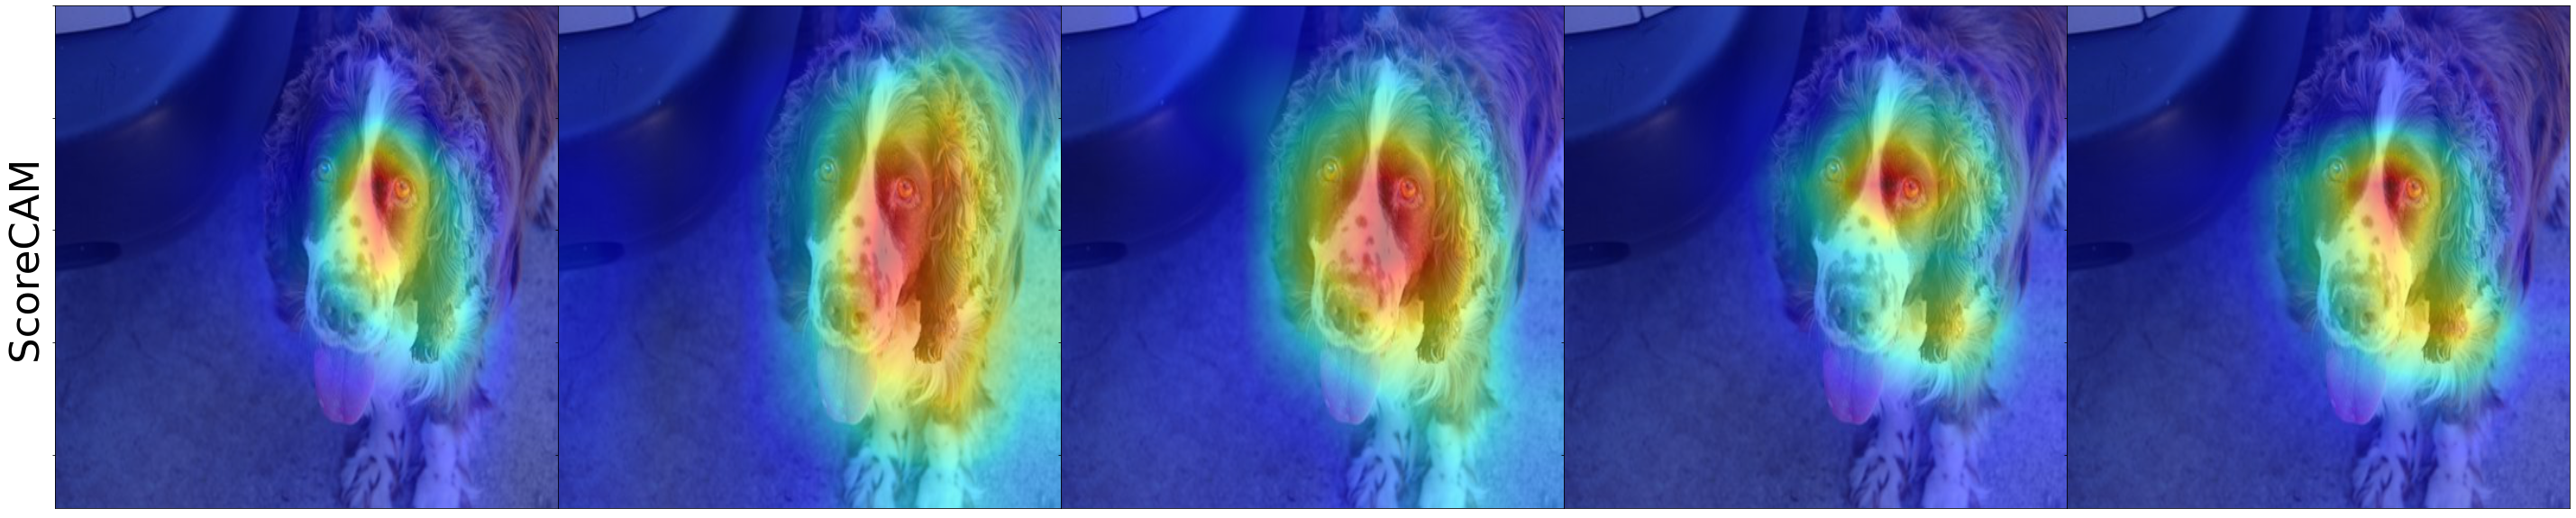

In [10]:
fig = plt.figure()
gs = fig.add_gridspec(1, len(activations), hspace=0, wspace=0)
axes = gs.subplots(sharex=True, sharey=True)
fig.set_size_inches(50, 35)
i = 0
for act in activations:
    axes[i].imshow(img, alpha=1, extent=(0,224,224,0),
                  interpolation='bilinear')
    axes[i].imshow(act,cmap="jet", alpha=0.5, extent=(0,224,224,0),
                  interpolation='bilinear')

    
    axes[i].set_xticks([])
    axes[i].set_yticklabels([])
    i+=1

axes.flat[0].set(ylabel="ScoreCAM")

## Guided Score-Cam

In [37]:
img = img2
prediction = CNN.predict(img)
class_idx = prediction[1]
activations = []
for model in models:
    activations.append(guided_gradcam(guided_backprop(model, img, class_idx), score_cam(model, img, class_idx)))

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
fig = plt.figure()
gs = fig.add_gridspec(1, len(activations), hspace=0, wspace=0)
axes = gs.subplots(sharex=True, sharey=True)
fig.set_size_inches(50, 35)
i = 0
for act in activations:
    axes[i].imshow(act,cmap="jet", alpha=1, extent=(0,224,224,0),
                  interpolation='bilinear')

    axes[i].set_xticks([])
    axes[i].set_yticklabels([])
    i+=1

axes.flat[0].set(ylabel="Guided ScoreCAM")

## Occlusion Sensitivity

In [7]:
img = img2
prediction = CNN.predict(img)
class_idx = prediction[1]
class_idx = 1
activations = []
for model in models:
    sensitivity_map, patched_images, preds = occlusion(model, img, class_idx, 25) 
    activations.append(cv2.resize(sensitivity_map, dsize=(20, 20), interpolation=cv2.INTER_CUBIC))

[Text(0, 0.5, 'Occlusion Sensivity Map')]

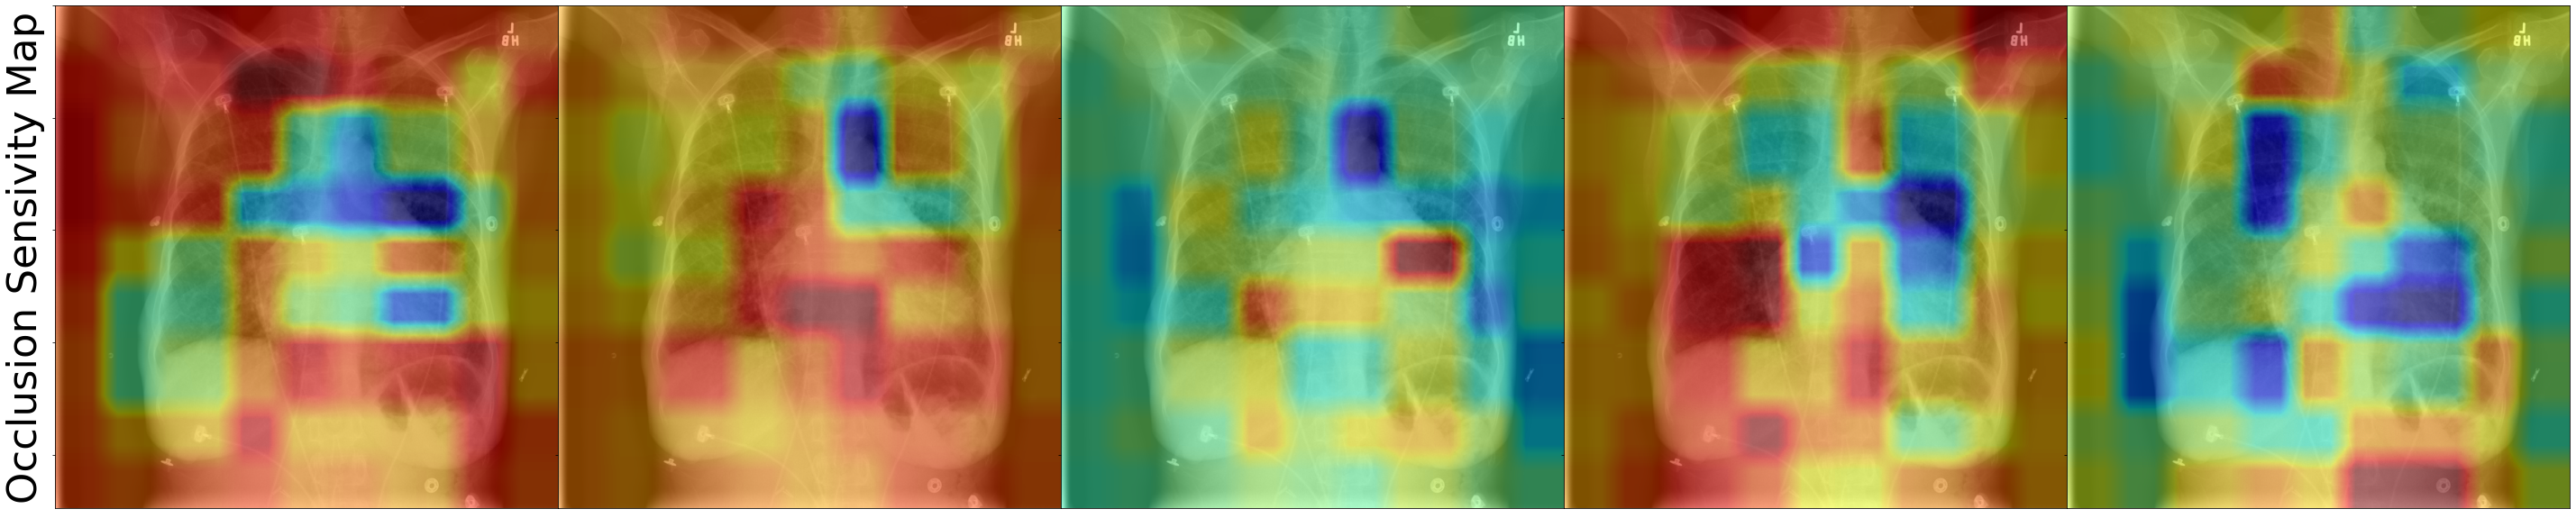

In [8]:
fig = plt.figure()
gs = fig.add_gridspec(1, len(activations), hspace=0, wspace=0)
axes = gs.subplots(sharex=True, sharey=True)
fig.set_size_inches(50, 35)
i = 0
for act in activations:
    axes[i].imshow(img, alpha=1, extent=(0,224,224,0),
                  interpolation='bilinear')
    axes[i].imshow(act,cmap="jet", alpha=0.5, extent=(0,224,224,0),
                  interpolation='bilinear')
    
    axes[i].set_xticks([])
    axes[i].set_yticklabels([])
    i+=1

axes.flat[0].set(ylabel="Occlusion Sensivity Map")

## Kernel Visualization

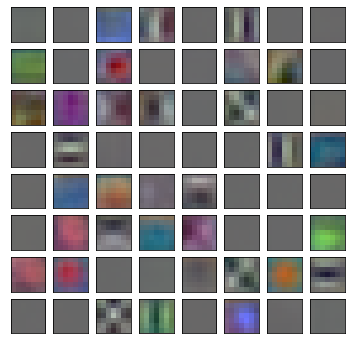

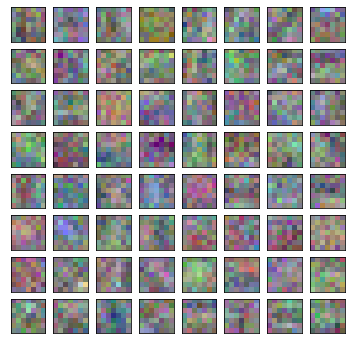

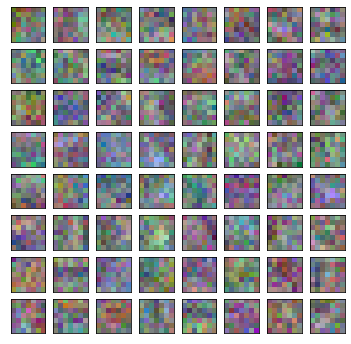

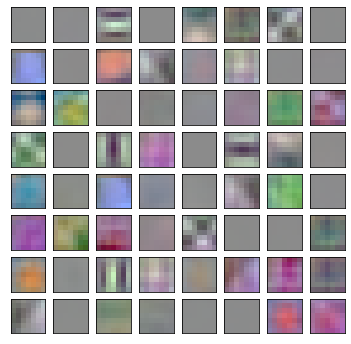

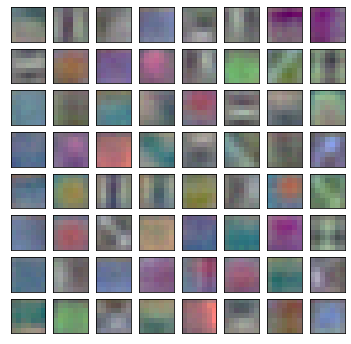

In [32]:
for learn in learners:
    layers = [
            # Those are the possible conv layers
            list(learn.model.children())[0],
       #     list(learn.model.children())[4][0].conv2,
       #     list(learn.model.children())[7][0].conv2
    ]
    visualize_kernel(learn, layers)